# Skill assessment - computation
***

**Author**: Chus Casado Rodr√≠guez<br>
**Date**: 20-03-2023<br>


**Introduction**:<br>
In this notebook I will analyse the EFAS skill in predicting flood events in general, i.e., looking whether events where predicted at some point in time, regardless of neither the offset nor the duration of the event.

**Questions**:<br>

* [ ] Take into account the model spread?
* [ ] Aggregate results by river/administrative area? EFAS aims at alerting administrations about incoming events in there administrative area, shouldn't that aggregation be included in the results?
* [ ] Remove extremely bad performing stations.

**Pending tasks**:<br>

* [x] Weighting the model average by the Brier score?
* [x] Sort stations by catchment area (or other order)?
* [x] Persistence
* [ ] Analyse only the periods/stations close to an observed event and compute f1 for this extraction. Later on, on the complementary subset of data another metric must be computed to avoid false positives, p.e., false alarm ratio.



**Interesting links**<br>
[Evaluation metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)<br>
[Cross entropy for machine learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)<br>
[Probability metrics for imbalanced classification](https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/)<br>
[ROC curves and precision-recall curves for imbalanced classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)<br>
[Instructions for sending EFAS flood notifications](https://efascom.smhi.se/confluence/display/EDC/Instructions+for+sending%2C+upgrading+and+deactivating+EFAS+Flood+Notifications)

In [1]:
import os
import sys
import operator
import glob
import numpy as np
import pandas as pd
import xarray as xr
# import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
from tqdm import tqdm_notebook

path_root = os.getcwd()

import warnings
warnings.filterwarnings("ignore")

os.chdir('../py/')
from computations import *
from plots import *
os.chdir(path_root)

## 1 Configuration

### 1.1 Notification criteria

#### Probability threshold

In [2]:
# probability thresholds
thresholds = np.arange(.05, .96, .05).round(2)
# thresholds = np.round(sigmoid(np.linspace(-10, 10, 50)), 5)
probabilities = xr.DataArray(thresholds, dims=['probability'], coords={'probability': thresholds})

#### Persistence

A list of tuples with two values: the first value is the width of the window rolling sum, and the second value the minimum number of positives in that window so that a notification is raised.

In [3]:
persistence = [(1, 1), (2, 2), (2, 3), (3, 3), (2, 4), (3, 4), (4, 4)]
persistence = {'/'.join([str(i) for i in pers]): pers for pers in persistence}

#### Leadtime

Notifications are only sent with a minimum leadtime (h).

In [4]:
min_leadtime = None

### 1.2 Output

In [5]:
name = 'EFAS'

# path where results will be saved
results_path = '../results/'
path_out = f'{results_path}skill/{name}/eventwise/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

In [6]:
# coordinate reference system when plotting maps
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))

## 2 Data

### 2.1 Stations

I load all the stations that where selected in a previous [notebook](3_0_select_stations.ipynb).

In [7]:
# load selected points for all the catchments
stations = pd.DataFrame()
catchments = []
folders = os.listdir(f'{results_path}reporting_points/')
for folder in folders:
    try:
        stn_cat = pd.read_csv(f'{results_path}reporting_points/{folder}/points_selected.csv', index_col='station_id')
        stations = pd.concat((stations, stn_cat))
        catchments.append(folder)
    except:
        continue
print('no. stations:\t\t\t{0}'.format(stations.shape[0]))

# remove unnecessary attributes
stations.drop(['rl1.5', 'rl2', 'rl10', 'rl20', 'rl50', 'rl100', 'rl200', 'rl500', 'strahler', 'pfafstetter', 'country'], axis=1, inplace=True)

# convert into integers
stations[['X', 'Y', 'area', 'rl5']] = stations[['X', 'Y', 'area', 'rl5']].astype(int)

no. stations:			900


### 2.2 Forecast: exceedance

I load the preprocessed forecast data. In a previous [notebook](4_0_forecast_exceedance_review.ipynb), the forecasted discharge was converted to probability of exceeding the 5-year return period threshold. The ouput of that process is a NetCDF file per station with the forecasted probability of exceedance. 

In [8]:
# find NetCDF files
path_forecast = '../data/exceedance/forecast/'
files = glob.glob(f'{path_forecast}*.nc')
files = [file for file in files if int(file.split(sep='\\')[-1].split('/')[-1].split('.')[0]) in stations.index]

# load data to a chunked DataArray
fore_exc = xr.open_mfdataset(files, combine='nested', concat_dim='id', chunks={'id': 1}).exceedance
fore_exc['id'] = fore_exc.id.astype(int)

# study period based on the extent of the forecast data
#start, end = [(fore_exc.forecast[i] + fore_exc.leadtime[i]).data for i in [0, -1]]
#start, end = [(date - np.datetime64('1970-01-01T01:00:00Z')) / np.timedelta64(1, 's') for date in [start, end]]
#start, end = [datetime.fromtimestamp(timestamp) for timestamp in [start, end]]

#print(f'Study period\nstart:\t{start}\nend:\t{end}')

##### Reformat data

To be able to compute skill in a simple manner, I need to reshape the exceedance forecast. Up until now, the exceedance forecast is saved in a matrix where the `forecast` is one dimension, and the `leadtime` is another dimension, in a way that there aren't missing values in the matrix. However, this shape is not convenient for comparing against the observed exceedances of the discharge threshold. Instead, I will reshape the original exceendance forecast into a new matrix in which a dimension named `datetime` represents actual date and time, and another dimension represents leadtime. In this way, a column in the matrix represents the same timestep and can be easily compared against observations. The drawback of this approach is that it will create missing values in the lower-left and upper-right corners of the matrix; therefore, I will remove these parts of the matrix (`trim=True`).

In [9]:
# reshape the DataArray of forecasted exceedance
pred = reshape_DataArray(fore_exc, trim=True, chunks={'id': 1})
del fore_exc

print(pred.dims)
print(pred.shape)

('id', 'model', 'leadtime', 'datetime')
(900, 4, 20, 2882)


### 2.3 Reanalysis: exceedance & events

I load the preprocessed reanalysis data. In a previous [notebook](2_2_reanalysis_preprocessing.ipynb), the reanalysis discharge data was preprocessed to create timeseries of exceedance over the 5-year return period threshold.

Out of the exceedance timeseries I calculate another timeseries of the onset of flood events.

no. events:			526
no. stations with events:	322


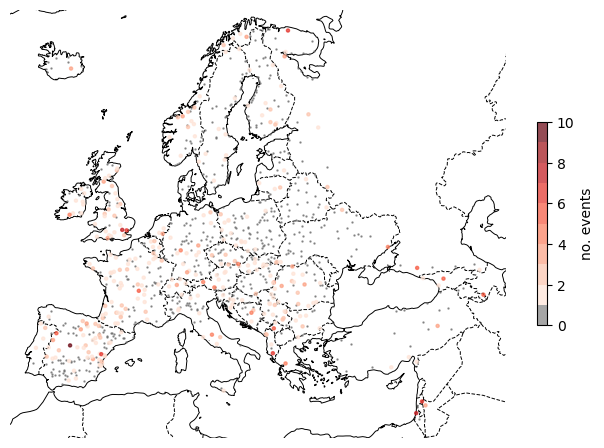

In [10]:
path_reanalysis = '../data/exceedance/reanalysis/'

# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = pd.read_parquet(f'{path_reanalysis}/exceedance_rl5.parquet')
rean_exc.columns = rean_exc.columns.astype(int)
rean_exc = rean_exc.loc[pd.to_datetime(pred.datetime.data), stations.index.tolist()]

# compute onsets of the flood events
rean_onsets = rean_exc.astype(int).diff(axis=0) == 1
rean_onsets.iloc[0,:] = rean_exc.iloc[0,:]

# create a DataArray with the number of observed events per station
n_events_obs = xr.DataArray(rean_onsets.sum(), dims=['id'], coords={'id': rean_onsets.columns.tolist()})
stations['n_events_5'] = n_events_obs.to_pandas()
print('no. events:\t\t\t{0}'.format(n_events_obs.sum().data))
del rean_onsets

# select stations with events
mask_stn = (n_events_obs > 0).to_pandas()
print('no. stations with events:\t{0}'.format(mask_stn.sum()))

# colormap used for the maps
cmap, norm = create_cmap('Reds', np.arange(0, n_events_obs.max(), 1), 'no. events', [0, (.5, .5, .5, .5)])
plot_map_stations(stations.X, stations.Y, n_events_obs.to_pandas(), mask=~mask_stn,
                  cmap=cmap, norm=norm, size=5, figsize=(8, 8),alpha=.7)
plt.colorbar(plot_map_stations.colorbar, shrink=.33, label='no. events')
plt.savefig(f'{path_out}/map_observed_events.png', dpi=300, bbox_inches='tight');

> ***Figure 1**. Number of observed flood events in the selected reporting points.Small gray dots represent points without observed events.*

The number of events has increased after giving priority to reporting points upstream during the selection process. Out of the 900 selected reporting points, 322 suffered a flood event in the last two years, summing up to a total of 526 observed flood events.

##### Reformat data

I convert the reanalysis data into a `xarray.DataArray`, which will be useful in the following steps.

In [11]:
# create a DataArray with observed threshold exceedance
obs = df2da(rean_exc, dims=['id', 'datetime'], plot=False, figsize=(16, 20), title='observed exceendace')
del rean_exc

# expected probability of an exceedance
obs = obs.astype(int)

print(obs.dims)
print(obs.shape)

('id', 'datetime')
(900, 2882)


The following plot is a graphical explanation of the new format in which forecast exceedance probability is stored. 

### 2.4 Weighing factors

In [12]:
# by the number of membes
weights_member = xr.open_dataarray(f'{path_out}weights_member.nc')

# by the Brier score
weights_brier = xr.open_dataarray(f'{path_out}weights_brier.nc', engine='netcdf4')

## 3 Assess skill

In this section I will compute the skill of the EFAS predictions in different ways. In all the following sections I will work with three metrics: recall, precision and the f1-score. The three metrics are based in the contingency table of hits ($TP$ for true positives), false alarms ($FP$ for false positives) and misses ($FN$ for false negatives).

$$recall = \frac{TP}{TP + FN}$$
$$precision = \frac{TP}{TP + FP}$$
$$f1 = \frac{2 \cdot TP}{2 \cdot TP + FN + FP}$$

### 3.2 Where events predicted at any point in time?

The objective of this section is to check if observed events where predicted at all, no matter leadtime.

To convert exceedance probability for each meteo forcing into predicted events we need to come up with a total exceedance probability, i.e., combine the probabilities of each meteo forcing into a single probability value. This total probability will later be compared against a probability threshold to discern events. I will test four different approaches:

* `current`:  the current notification criteria. At least a probabilistic and deterministic model must exceed the probability threshold.
* `model_mean`: a simple mean over the 4 forcings.
* `member_weighted`: a mean weighted by the number of members that each meteo forcing contains. In this approach the probabilistic models, specifically that from ECMWF, prevail.
* `brier_weighted`: a mean weighted by the previously calculated Brier score. This is an approach in between the simple mean and the mean weighted by the number of members. Probabilistic forcings will prevail because they proved to be more skillful, but their relative importance is lower than in the previous approach.

#### 3.2.1 Exceedance over probability threshold

In this section I will first compute the total probability using the four approaches previously explained, and then compare the results against the probability thresholds. The outcome will be a boolean dataset of exceedances thresholds named `pred_exc` with 5 dimensions (approach, id, leadtime, datetime, probability).

##### Current

In [13]:
# exceedance according to current criteria
deterministic = (pred.sel(model=['EUD', 'DWD']) >= probabilities).any('model')
probabilistic = (pred.sel(model=['EUE', 'COS']) >= probabilities).any('model')
current = deterministic & probabilistic

##### Model mean

In [14]:
# exceedance according to mean over models
model_mean = pred.mean('model', skipna=True) >= probabilities

##### Member weighted

In [15]:
# exceedance according to the mean over models weighted by the number of members
member_weighted = pred.weighted(weights_member).mean('model', skipna=True) >= probabilities

##### Brier weighted

To create a weight based on the Brier score I need to invert the values, since lower Brier score values represent better models. Therefore, I compute the inverse of the squared Brier score. To normalize weights (values between 0 and 1) I divide the previous weight matrix by its sum over models.

In [16]:
# exceedance according to the mean over models weighted by the inverse Brier score
brier_weighted = pred.weighted(weights_brier.fillna(0)).mean('model', skipna=True) >= probabilities

##### Combine approaches

In [17]:
# merge all total probability approaches in a single DataArray
pred_exc = xr.Dataset({
                        'current': current,
                        'model_mean': model_mean,
                        'member_weighted': member_weighted,
                        'brier_weighted': brier_weighted,
                        }).to_array(dim='approach')

pred_exc.dims, pred_exc.shape

del pred

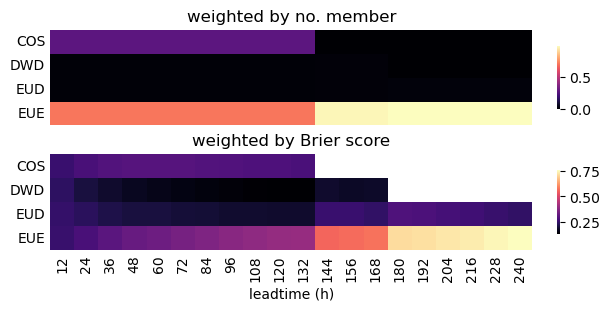

In [18]:
# heatmap of weights
fig, axes = plt.subplots(nrows=2, figsize=(6, 3), constrained_layout=True, sharex=True, sharey=True)
Weights = xr.Dataset({'no. member': weights_member, 'Brier score': weights_brier})
for i, (ax, (var, da)) in enumerate(zip(axes, Weights.items())):
    htm = plot_DataArray(da, vmin=0, vmax=1, ax=ax, ytick_step=1, xtick_step=1, title=f'weighted by {var}', cbar_kws={'shrink': .66})
    if i == len(axes) - 1:
        ax.set_xlabel('leadtime (h)')

> ***Figure 5**. Weighting matrixes used to compute total probability according to the number of members of the meteorological forcing (top) or the skill measured in terms of Brier score (bottom).*

The previous plot shows the weighting factors for the mean weighted by the number of members of each model (top), and the mean weighted by the performace of the model measured in terms of Brier score (bottom). When taking into account the number of members, obviously COSMO-LEPS and EUE get the vast majority of the weight, rendering no importance to any of the deterministic models. Between the two probabilistic models, EUE prevails over COSMO-LEPS, even though we've seen that their performance is comparable. However, when weighting according to performance, COSMO-LEPS and EUE get a very similar value during the leadtime span for which COSMO-LEPS is available. The probabilistic models have lower weights, but not as insignificat as when weighting by the number of members. In this sense, this last weighting method is a halfway point between the simple model mean and the mean weighted by the number of members.

#### 3.2.2 Compute skill

The computation of skill consists on three steps:

1. Define events according to the notification criteria (persistence and minimum leadtime). The probability threshold was already taken into account when computing the exceedance over threshold in the previous section.

2. Compute hits, misses and false alarms by comparing observation and predictions. At this step a window function is applied to count as hits predictions that have minor time lags compared with the observation.

3. Compute skill metrics (recall, precicion and f1).

##### Define events

In [21]:
for min_leadtime in pred_exc.leadtime.data[1::2]:
    print(min_leadtime)

24
48
72
96
120
144
168
192
216
240


In [28]:
persistence

{'1/1': (1, 1),
 '2/2': (2, 2),
 '2/3': (2, 3),
 '3/3': (3, 3),
 '2/4': (2, 4),
 '3/4': (3, 4),
 '4/4': (4, 4)}

In [29]:
resample = None

for min_leadtime in tqdm_notebook([60]):#pred_exc.leadtime.data[1::2]):

    path = f'{path_out}no_resample_leadtime_{min_leadtime}/'
    if not os.path.exists(path):
        os.makedirs(path)

    for label, pers in tqdm_notebook(persistence.items()):
        
        if label != '1/1':
            continue

        #  check if the output files already exist
        file_suffix = f'_persistence_{label}.nc'.replace('/', '-')
        nc_files = [f for f in glob.glob(f'{path}*{file_suffix}') if 'TP' in f or 'FN' in f or 'FP' in f]
        if len(nc_files) == 3:
            print(f'Persistence {label} had already been computed.')
            continue

        # compute predicted events
        pred_events = compute_events(pred_exc, persistence=pers, resample=resample, min_leadtime=min_leadtime)

        # calculate the number of predicted events
        n_events_pred = count_events(pred_events).compute()
        # export as NetCDF
        file_out = f'{path}predicted_events{file_suffix}'
        print(f'Exporting file {file_out}')
        n_events_pred.to_netcdf(file_out)

        # compute hits, misses and false alarms
        if 'leadtime' in pred_events.dims:
            hits = [compute_hits(obs, pred_events.sel(leadtime=lt), center=True, w=5) for lt in pred_events.leadtime.data]
            hits = xr.concat(hits, dim='leadtime').compute()
        else:
            hits = compute_hits(obs, pred_events, center=True, w=5).compute()
        # export results as NetCDF
        for var, da in hits.items():
            file_out = f'{path}{var}{file_suffix}'
            print(f'Exporting file {file_out}')
            da.to_netcdf(file_out)

        del pred_events, hits, n_events_pred

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../results/skill/EFAS/eventwise/no_resample_leadtime_60/predicted_events_persistence_1-1.nc
Exporting file ../results/skill/EFAS/eventwise/no_resample_leadtime_60/TP_persistence_1-1.nc
Exporting file ../results/skill/EFAS/eventwise/no_resample_leadtime_60/FN_persistence_1-1.nc
Exporting file ../results/skill/EFAS/eventwise/no_resample_leadtime_60/FP_persistence_1-1.nc
